In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

import os
import time
import math
import numpy as np
import skimage.io as io
import cv2
from torchsummary import summary

from utilities import FilterKernel
from di_dataset2 import DepthImageDataset, collate_batch

2022-03-07 21:02:48.588423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/home/patricknit/.mujoco/mjpro150/bin
2022-03-07 21:02:48.588439: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C

In [2]:
MAX_RANGE = 10.0 # max range of depth image [m]
batch_size = 32

# Data

In [3]:
tfrecord_folder='../../../rl_data/tfrecord'
tfrecord_test_folder='../../../rl_data/tfrecord/test'

train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size) # 176 tfrecords
test_dataset = DepthImageDataset(tfrecord_folder=tfrecord_test_folder, batch_size=batch_size) # 20 tfrecords

train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, collate_fn=collate_batch)
    
dataiter = iter(train_loader)
image_batch, *_ = dataiter.next() # image, height, width, depth
print("Nicolai is so cool!!!")

2022-03-07 21:02:49.764141: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-07 21:02:49.764178: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (patricknit-OptiPlex-7060): /proc/driver/nvidia/version does not exist
2022-03-07 21:02:49.764496: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading tfrecords... 	['../../../rl_data/tfrecord/data161.tfrecords']
Iterating length... 	Done: 69
Loading tfrecords... 	['../../../rl_data/tfrecord/test/data180.tfrecords']
Iterating length... 	Done: 64
gotcha
Nicolai is so cool!!!


# Filtering

In [4]:
def imshow(image):
    io.imshow(image, cmap="gray")
    io.show()

6.8077064


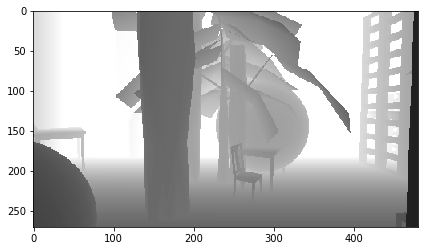

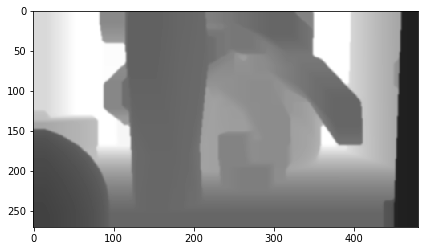

3.199691


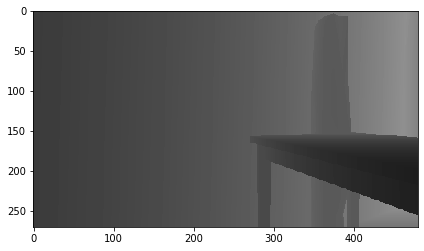

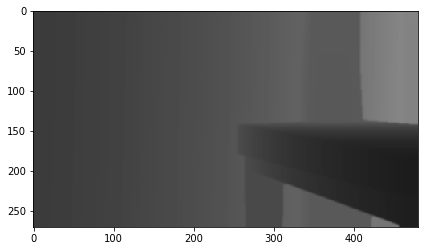

5.344845


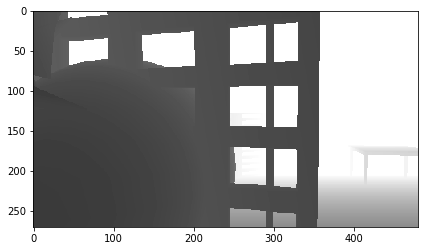

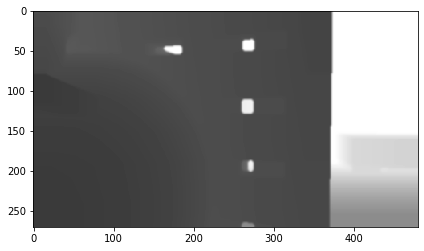

7.96242


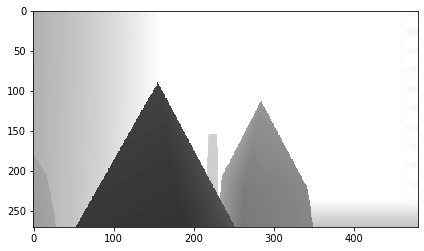

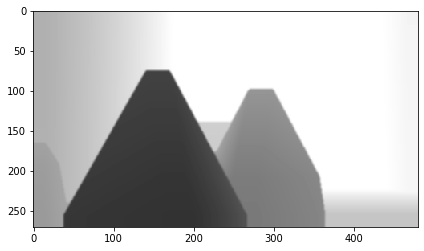

3.8311226


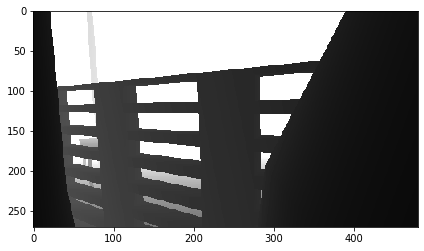

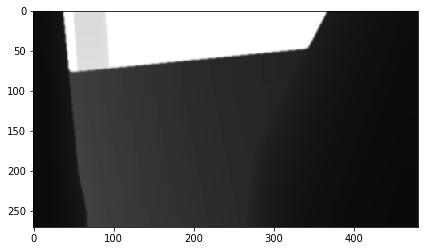

8.900867


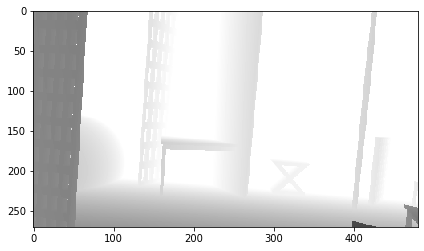

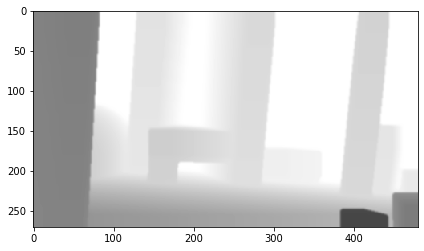

In [5]:
def fill_in_fast(depth_map, max_depth=100.0, custom_kernel=FilterKernel.DIAMOND_KERNEL_5,
                extrapolate = False, blur_type='bilateral', show_process=False):
    """Fast, in-place depth completion.
    Args:
        depth_map: projected depths
        max_depth: max depth value for inversion
        custom_kernel: kernel to apply initial dilation
        extrapolate: whether to extrapolate by extending depths to top of
            the frame, and applying a 31x31 full kernel dilation
        blur_type:
            'bilateral' - preserves local structure (recommended)
            'gaussian' - provides lower RMSE
    Returns:
        depth_map: dense depth map
    """
    #process_dict = collections.OrderedDict()
    #process_dict['depth_map in'] = copy.copy(depth_map)
    
    # Invert
    valid_pixels = (depth_map > 0.1) # TODO: 0.1 or min_range?
    depth_map[valid_pixels] = max_depth - depth_map[valid_pixels]

    # Dilate
    depth_map = cv2.dilate(depth_map, custom_kernel)
    #process_dict['depth_map dilate'] = copy.copy(depth_map)

    # Hole closing
    depth_map = cv2.morphologyEx(depth_map, cv2.MORPH_CLOSE, FilterKernel.FULL_KERNEL_5)
    #process_dict['depth_map hole closing'] = copy.copy(depth_map)

    # Fill empty spaces with dilated values
    empty_pixels = (depth_map < 0.1) # TODO: 0.1 or min_range? (below also)
    dilated = cv2.dilate(depth_map, FilterKernel.FULL_KERNEL_7)
    depth_map[empty_pixels] = dilated[empty_pixels]

    # Extend highest pixel to top of image
    if extrapolate:
        top_row_pixels = np.argmax(depth_map > 0.1, axis=0)
        top_pixel_values = depth_map[top_row_pixels, range(depth_map.shape[1])]

        for pixel_col_idx in range(depth_map.shape[1]):
            depth_map[0:top_row_pixels[pixel_col_idx], pixel_col_idx] = \
                top_pixel_values[pixel_col_idx]

        # Large Fill
        empty_pixels = depth_map < 0.1
        dilated = cv2.dilate(depth_map, FilterKernel.FULL_KERNEL_31)
        depth_map[empty_pixels] = dilated[empty_pixels]

    # Median blur
    depth_map = cv2.medianBlur(depth_map, 5)

    # Bilateral or Gaussian blur
    if blur_type == 'bilateral':
        # Bilateral blur
        depth_map = cv2.bilateralFilter(depth_map, 5, 1.5, 2.0)

    elif blur_type == 'gaussian':
        # Gaussian blur
        valid_pixels = (depth_map > 0.1)
        blurred = cv2.GaussianBlur(depth_map, (5, 5), 0)
        depth_map[valid_pixels] = blurred[valid_pixels]

    # Invert
    valid_pixels = (depth_map > 0.1)
    depth_map[valid_pixels] = max_depth - depth_map[valid_pixels]
    #process_dict['depth_map hole filtering'] = copy.copy(depth_map)
    #if show_process:
    #    return depth_map, process_dict
    return depth_map

def max_to_255(image):
    image = image * 255 / MAX_RANGE
    image = image.astype('uint8')
    image = np.array(image)
    return image
    
extrapolate = True
blur_type = 'gaussian'

for image in image_batch[:6]:
    image = image.squeeze().numpy() * MAX_RANGE
    print(image.mean())
    
    image_filtered = fill_in_fast(np.copy(image), extrapolate=extrapolate, blur_type=blur_type, custom_kernel=FilterKernel.FULL_KERNEL_31)
    image_filtered = max_to_255(image_filtered)
    image = max_to_255(image)
    
    imshow(image)
    imshow(image_filtered)